# A Classifyre for the Crypto Punks Dataset

In [1]:
import torch
from torch import nn
from torch.utils.data import SubsetRandomSampler, RandomSampler
import matplotlib.pyplot as plt

In [8]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), 'firepunks'))

from firepunks import datasets as DS
from firepunks import images as IMGS

In [3]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
batch_size = 32

In [4]:
# filter = ['male', 'female']
# filter = L.ALL_FILTERS
# filter = ['3DGlasses', 'wildHair', 'cigarette']
filter = ['alien', 'ape', 'zombie', 'male', 'female']

punks_ds = DS.CPunksDataset(filter, test_size=1000)

train_sampler = SubsetRandomSampler(punks_ds.train_idx)
test_sampler = SubsetRandomSampler(punks_ds.test_idx)

train_loader = torch.utils.data.DataLoader(
    dataset=punks_ds, batch_size=batch_size, shuffle=False, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset=punks_ds, batch_size=batch_size, shuffle=False, sampler=test_sampler
)

In [11]:
# Explore Dataset
punk, labels = punks_ds[42]
print(f'shape: {punk.shape}')
for f,l in zip(filter, labels):
    print(f"{f}: {l}")
IMGS.write_mpimg(punk, "42.jpg")

print("--")


# Explore Loader
punk_batch, label_batch = next(iter(train_loader))
print(f'punk batch: {punk_batch.shape}')
print(f'label batch: {label_batch.shape}')
print("--")
print(punk_batch[0].shape)
for f,l in zip(filter, label_batch[0]):
    print(f"{f}: {l}")


# Write new image with loaded data
IMGS.write_mpimg(punk_batch[0].numpy(), "0.jpg")

shape: (24, 24, 4)
alien: 0
ape: 0
zombie: 0
male: 0
female: 1
--
punk batch: torch.Size([32, 24, 24, 4])
label batch: torch.Size([32, 5])
--
torch.Size([24, 24, 4])
alien: 0
ape: 0
zombie: 0
male: 0
female: 1


In [16]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(24*24*4, 200),
    nn.ReLU(),
    nn.Linear(200, 150),
    nn.ReLU(),
    nn.Linear(150, len(filter)),
    nn.ReLU()
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()

model.to(device)


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2304, out_features=200, bias=True)
  (2): ReLU()
  (3): Linear(in_features=200, out_features=150, bias=True)
  (4): ReLU()
  (5): Linear(in_features=150, out_features=5, bias=True)
  (6): ReLU()
)

In [17]:
num_epoch = 10
training_loss = 0
test_loss = 0


for epoch in range(num_epoch):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.type(torch.float64))
        loss.backward()
        optimizer.step()
        training_loss += loss.item()

    print('====> Epoch[{}/{}], loss: {:.6f}'.format(
        epoch + 1, num_epoch, loss.data.item()
    ))

    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels.type(torch.float64))

        test_loss /= len(test_loader.dataset)
        print('====> Test[{}/{}],  loss: {:.6f}'.format(
            epoch + 1, num_epoch, test_loss.data.item()
        ))


====> Epoch[1/10], loss: 0.606431
====> Test[1/10],  loss: 0.001933
====> Epoch[2/10], loss: 0.207939
====> Test[2/10],  loss: 0.000663
====> Epoch[3/10], loss: 0.092836
====> Test[3/10],  loss: 0.000296
====> Epoch[4/10], loss: 0.090272
====> Test[4/10],  loss: 0.000288
====> Epoch[5/10], loss: 0.058410
====> Test[5/10],  loss: 0.000187
====> Epoch[6/10], loss: 0.027145
====> Test[6/10],  loss: 0.000087
====> Epoch[7/10], loss: 0.682462
====> Test[7/10],  loss: 0.002174
====> Epoch[8/10], loss: 0.024035
====> Test[8/10],  loss: 0.000077
====> Epoch[9/10], loss: 0.027603
====> Test[9/10],  loss: 0.000088
====> Epoch[10/10], loss: 0.017511
====> Test[10/10],  loss: 0.000056


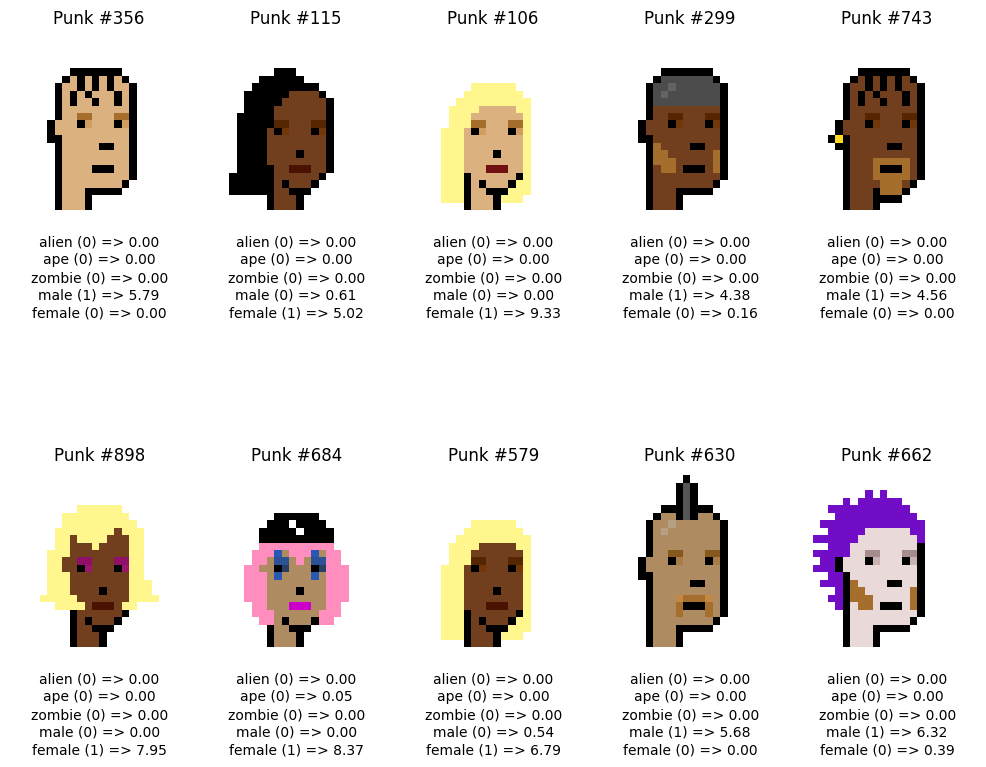

In [18]:

samples = (s for s in RandomSampler(punks_ds.test_idx))

fig, ax = plt.subplots(2, 5, figsize=(10, 10))

for i in range(2):
    for j in range(5):
        idx = next(samples)
        img, label = punks_ds[idx]
        img_tensor = torch.Tensor([img.flatten()]).to(device)

        ax[i,j].imshow(img)
        ax[i,j].set_title(f'Punk #{idx}')
        ax[i,j].axis('off')

        result = model(img_tensor)

        height = -0.2
        for f, l, r in zip(filter, label, result[0]):
            ax[i,j].text(
                0.5, height, 
                f'{f} ({l}) => {r:.2f}',
                fontsize=10, 
                ha='center',
                transform=ax[i,j].transAxes
            )
            height -= 0.1


plt.tight_layout()
plt.show()
